In [10]:
# numpy and plotting
import numpy as np
# import pylab
# import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
# pyFAI
import pyFAI
from pyFAI.geometry import Geometry as PoniGeometry
# pygix
import pygix
import fabio
import pandas as pd
from pathlib import Path
np.seterr(divide = 'ignore') 
from PIL import Image
# %matplotlib widget

def load_poni(file_name: Path) -> PoniGeometry:
    geometry = PoniGeometry()
    geometry.load(file_name)
    return geometry


def find_angles(x, y, z, incident):
    tan = np.tan(incident)
    r_inv_len = 1. / np.sqrt(x * x + y * y + z * z)
    sin_alpha = (np.sin(incident) * tan + np.cos(incident)) * (z - x * tan) * r_inv_len
    alpha_f = np.arcsin(sin_alpha)
    twotheta = np.arcsin(y / np.cos(alpha_f) * r_inv_len)
    return alpha_f, twotheta

def q_unit_per_pixel(pg: PoniGeometry, incident_angle_degrees: float, detector_shape: tuple):
    dety = pg.get_pixel1() * np.arange(detector_shape[0])[::-1].reshape((detector_shape[0], 1)) - pg.get_poni1()
    # poni2_adj = detector_shape[1] * pg.get_pixel2() - pg.get_poni2()
    detx = pg.get_pixel2() * np.arange(detector_shape[1]).reshape((1, detector_shape[1])) - pg.get_pixel2()
    incident_angle = incident_angle_degrees * 0.017453292519943295769236907684886     # convert to rads
    scattered_alpha, scattered_2theta = find_angles(pg.get_dist(), detx, dety, incident_angle)
    cosalpha = np.cos(scattered_alpha)
    costwotheta = np.cos(scattered_2theta)
    qx = cosalpha * costwotheta - np.cos(incident_angle)
    qy = cosalpha * np.sin(scattered_2theta)
    qz = np.sin(incident_angle) + np.sin(scattered_alpha)
    return np.array([np.sqrt(qx * qx + qy * qy) * ((detx > 0) * 2 - 1), qz])

def rebin(pg: PoniGeometry, raw_data, q_unit):
    modified_len_inv = pg.get_dist() / np.sqrt(1 - (q_unit[0] * q_unit[0] + q_unit[1] * q_unit[1]))
    y_lab = modified_len_inv * q_unit[0]
    z_lab = modified_len_inv * q_unit[1]
    
def rebin_broken(raw_data, q):
    max_qx = np.max(q[0,:,-1] - q[0,:,0])
    row_ind = np.argmax(q[0,:,-1] - q[0,:,0])
    max_qz = np.max(q[1,0,:] - q[1,-1,:])
    col_ind = np.argmax(q[1,0,:] - q[1,-1,:])
    print(max_qz, max_qx)
    print(row_ind, col_ind)
    qx_loc = np.round((q.shape[2] / max_qx) * (q[0] - q[0, row_ind, -1])).astype(np.uint32)
    qz_loc = np.round((q.shape[1] / max_qz) * (q[1] - q[1, -1, col_ind])).astype(np.uint32)
    print(np.min(qx_loc), np.max(qx_loc))
    print(np.min(qz_loc), np.max(qz_loc))
    data = np.zeros(np.array(raw_data.shape) + 1, dtype=np.uint32)
    for rr in range(raw_data.shape[0]):
        for cc in range(raw_data.shape[1]):
            row = qz_loc[rr, cc]
            col = qx_loc[rr, cc]
            data[row, col] += raw_data[rr, cc]
    return data

c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pyopencl\cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_csr: cannot import name 'ocl_azim_csr' from 'pyFAI' (c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_lut for: cannot import name 'ocl_azim_lut' from 'pyFAI' (c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_sort for: cannot import name 'ocl_sort' from 'pyFAI' (c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pyFAI\__init__.py)


931.1350262989376 1491.3083841400344


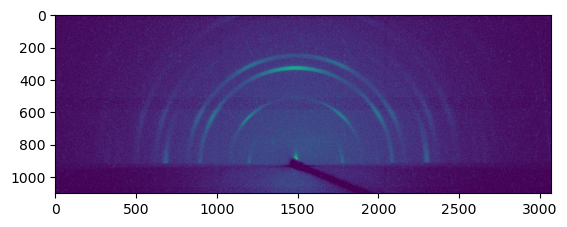

In [12]:
# directory = Path("D:\\OneDrive - UCB-O365\\Rogerslab3\\Teddy\\TPP Films\\BTB-TPP\\2024 Film Growth\\Film 1\\GIWAXS TT5-06")
directory = Path("C:\\Users\\Teddy\\OneDrive - UCB-O365\\Rogerslab3\\Teddy\\TPP Films\\BTB-TPP\\2024 Film Growth\\Film 1\\GIWAXS TT5-06")
filename = "GIWAXS-30min-BTBaTPP-teddy-20240130"
data = fabio.open(directory / (filename + ".tif")).data
data[np.where(data > (1 << 30))] = 0
pg = load_poni(directory / "cal.poni")
print(float(data.shape[0]) - pg.get_poni1() / pg.get_pixel1(), float(data.shape[1]) - pg.get_poni2()/ pg.get_pixel2())
# q = q_per_pixel(pg, 0.2, data.shape)
plt.imshow(np.log10(data + 1))


In [27]:
pg.get_shape()
pg.poni1

0.012814873027579674

In [19]:
data_transformed = rebin(data, q)


22031542756.815926 43667533256.825745
0 1
0 4294967295
0 1102


IndexError: index 4294964226 is out of bounds for axis 1 with size 3071

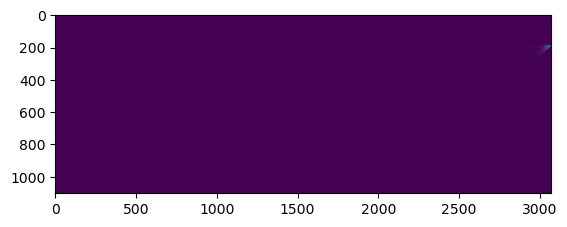

In [4]:
plt.imshow(np.log10(data_transformed+1))

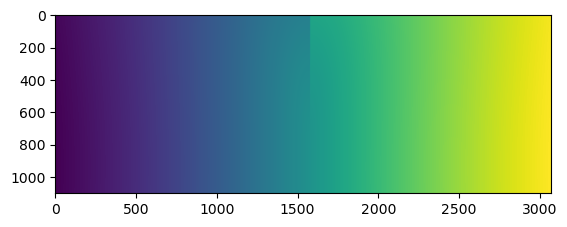

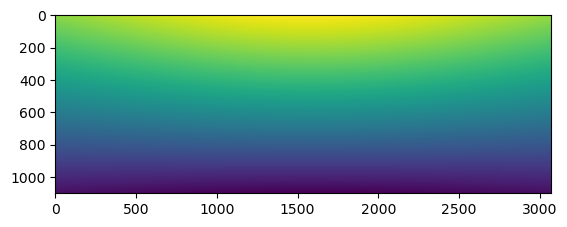

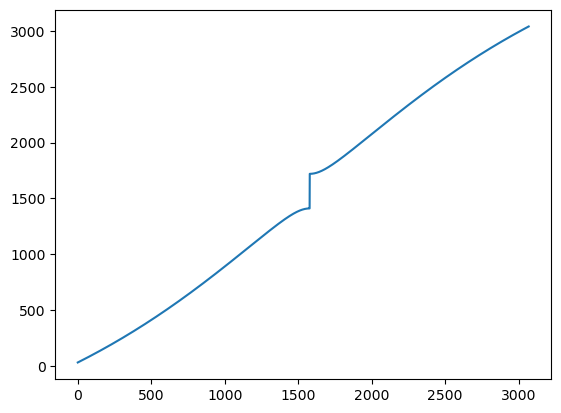

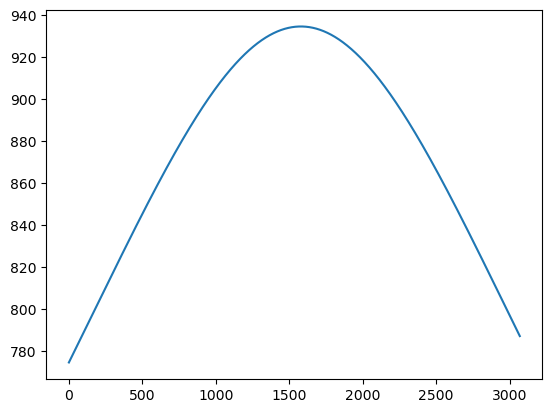

In [105]:
plt.figure()
plt.imshow(qx_rescale)
plt.figure()
plt.imshow(qz_rescale)
plt.figure()
plt.plot(qx_rescale[200, :])
plt.figure()
plt.plot(qz_rescale[200, :])

-2.815586657233024
8.860050960540457e-07


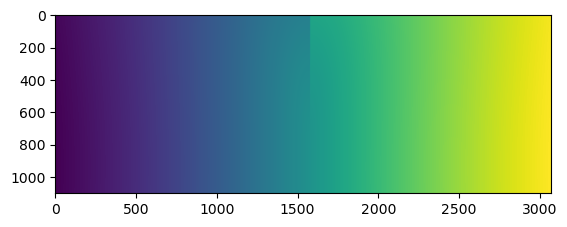

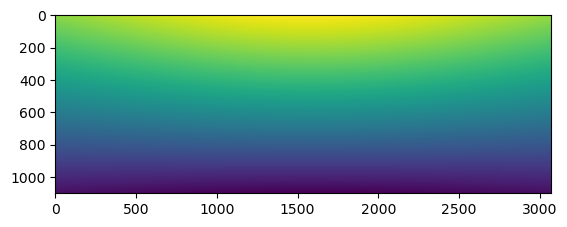

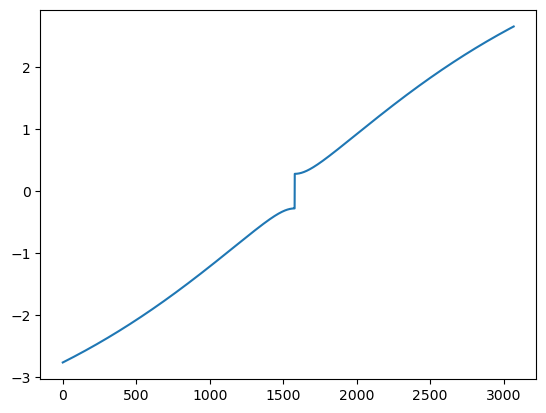

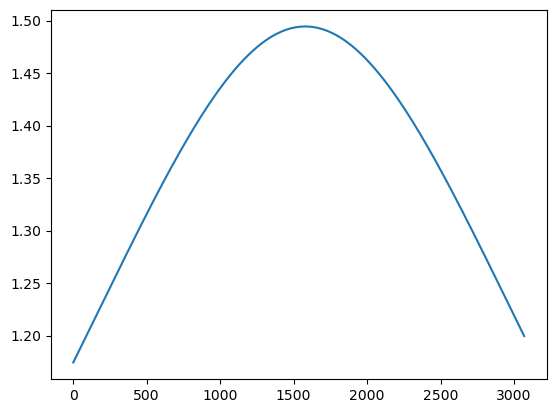

In [89]:
plt.figure()
plt.imshow(q[0])
plt.figure()
plt.imshow(q[1])
plt.figure()
plt.plot(q[0, 200, :])
plt.figure()
plt.plot(q[1, 200, :])
print(np.min(q[0]))
print(np.min(np.abs(q[1])))


<class 'numpy.ndarray'>
0
109


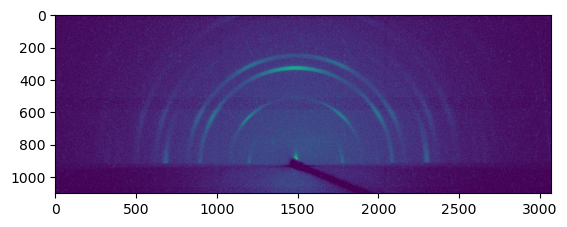

In [13]:
# stitch_cols = 3
# stitch_rows = 2
# for sc in range(1, stitch_cols + 1):
#     for sr in range(1, stitch_rows + 1):
#         file = directory / f"1_{sc}_{sr}"
#         print(file)

### Load the image data from the tiff. This notebook will need to be in the same folder as the tiff and .poni file
directory = Path("C:\\Users\\Teddy\\OneDrive - UCB-O365\\Rogerslab3\\Teddy\\TPP Films\\BTB-TPP\\2024 Film Growth\\Film 1\\GIWAXS TT5-06")
# directory = Path("D:\\OneDrive - UCB-O365\\Rogerslab3\\Teddy\\TPP Films\\BTB-TPP\\2024 Film Growth\\Film 1\\GIWAXS TT5-06")
filename = "GIWAXS-30min-BTBaTPP-teddy-20240130"
data = fabio.open(directory / (filename + ".tif")).data
print(type(data))

"""pylab.close('all')

fig=pylab.figure(); gs = gridspec.GridSpec(1, 1); ax1 = plt.subplot(gs[0,0])
for ax in fig.get_axes():
    ax.tick_params(which='both', color='k'); #ax.set_facecolor(LBLU)
ax1.set_xlabel("x-pixel (#)"); ax1.set_ylabel("y-pixel (#)"); ax1.yaxis.set_ticks_position('both'); ax1.xaxis.set_ticks_position('both');# ax1.set_facecolor(LBLU)

ax1.imshow(np.log(data), vmin=1, vmax=8, origin='lower')"""

# remove -1 from data. fabio imports data as uint32, so -1 is 2^32-1
data[np.where(data == (1 << 32) - 1)] = 0

plt.imshow(np.log(data+1))
print(np.min(data))
print(np.max(data))


In [14]:
### Load the poni file that the extraction code wrote from the .rasx file. This is used to correct the data.
pg = pygix.Transform()
pg.load(directory / "cal.poni")
print(data.shape)
print(pg.get_dist())
### Load the poni file that the extraction code wrote from the .rasx file

(1102, 3070)
0.13902343368236345


pixel size = 7.5e-05 x 7.5e-05 m
0.012814873027579674
0.11840187118949741
size = 0.08264999999999999 x 0.23024999999999998 m
[0.15504989 0.5142318 ]
(1102, 3070)
(1102, 3070)


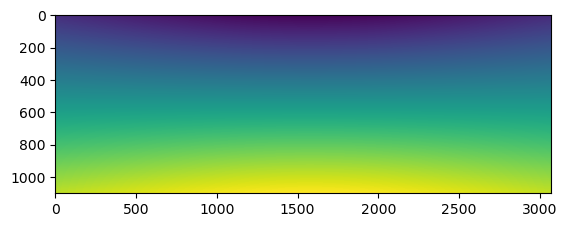

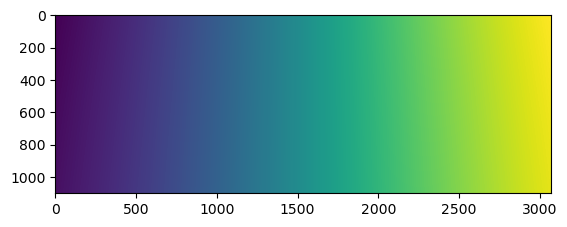

In [15]:
print(f"pixel size = {pg.get_pixel1()} x {pg.get_pixel2()} m")
print(pg.get_poni1())
print(pg.get_poni2())
data_size = pg.get_pixel1() * np.array(data.shape)
print(f"size = {data_size[0]} x {data_size[1]} m")
print(np.array([pg.get_poni1(), pg.get_poni2()]) / data_size)

pixel_locs_y = pg.get_pixel1() * np.arange(data.shape[0]).reshape((data.shape[0], 1)) - pg.get_poni1()
pixel_locs_x = pg.get_pixel2() * np.arange(data.shape[1]).reshape((1, data.shape[1])) - pg.get_poni2()

alphas, twothetas = find_angles(pg.get_dist(), pixel_locs_x, pixel_locs_y, .2)
print(alphas.shape)
print(twothetas.shape)
plt.figure()
plt.imshow(alphas)
plt.figure()
plt.imshow(twothetas)


3235964
3208026.8


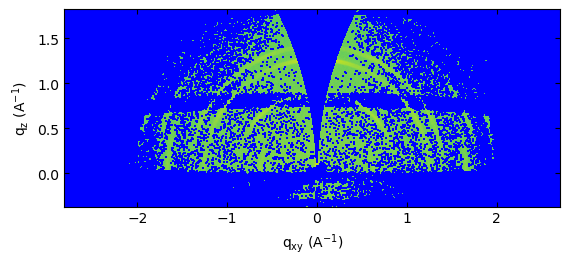

In [23]:
pg.sample_orientation = 1    # 1 is horizontal, 2 is vertical, 3 is 1*180 deg, 4 is 2*180 deg
pg.incident_angle = .25   # beam to sample angle (degrees)
# pg.tilt_angle = 0.      # azimuthal sample tilt (degrees)
# pg.rot1 = 0     # z-axis (radians)
# pg.rot2 = pg.incident_angle * np.pi / 180.     # y-axis (radians)
# pg.rot3 = 0     # x-axis (radians)

### Transform the data using the grazing incidence correction
ii_2d, qxy_2d, qz_2d = pg.transform_reciprocal(data, mask=None, method = 'bbox')

fig = plt.figure(facecolor="w")

# gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot()#gs[0, 0])
for ax in fig.get_axes():
    ax.tick_params(which='both', color='k', direction = 'in')
    ax.set_facecolor("b")
ax1.set_xlabel("q$_\mathregular{xy}$ (A$^{-1}$)")
ax1.set_ylabel("q$_\mathregular{z}$ (A$^{-1}$)")
ax1.yaxis.set_ticks_position('both'); ax1.xaxis.set_ticks_position('both')
pos = ax1.imshow(np.log10(ii_2d),
                 extent=(np.min(qxy_2d)/10, np.max(qxy_2d)/10, -np.max(qz_2d)/10, -np.min(qz_2d)/10))#,
                 #vmin = 0, vmax = 3)
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#fig.colorbar(pos, cax=cax)
#plt.figure()
#plt.imshow(np.log(data + 1))
#plt.figure()
#plt.imshow(ii_2d)
#plt.figure()
#plt.imshow(np.log(ii_2d + 1))
#plt.figure()
#plt.imshow(np.log(ii_2d * 10))
#plt.figure()
#logii = np.log(ii_2d)
#logii[np.where(logii < 0)] = 0
#plt.imshow(logii)


def save_tiff(filename, image_array):
    im = Image.fromarray(image_array)
    im.save(filename)

print(np.sum(data))
print(np.sum(ii_2d))

#save_tiff(directory / (filename + "_transform.tif"), )


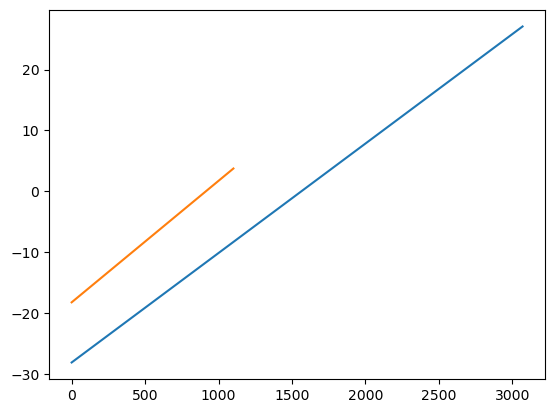

In [24]:
plt.plot(qxy_2d)
plt.plot(qz_2d)

In [5]:
ii_cake, q_cake_chi_cake = pg.transform_polar(data)
plt.imshow(np.log10(ii_cake + 1))

NameError: name 'pg' is not defined

In [ ]:
ii_1d, q_1d = pg.integrate_1d(data)

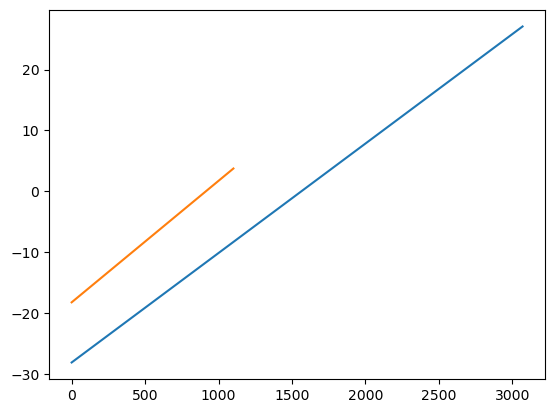

In [18]:
plt.plot(qxy_2d)
plt.plot(qz_2d)

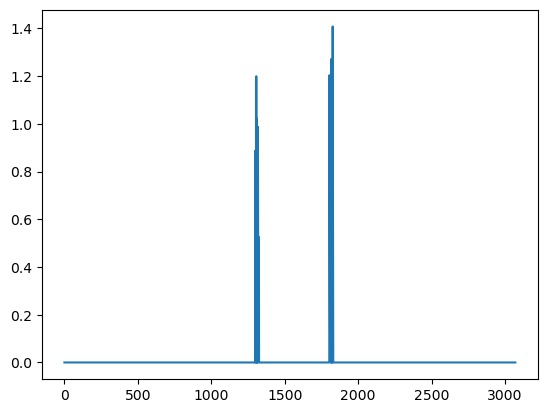

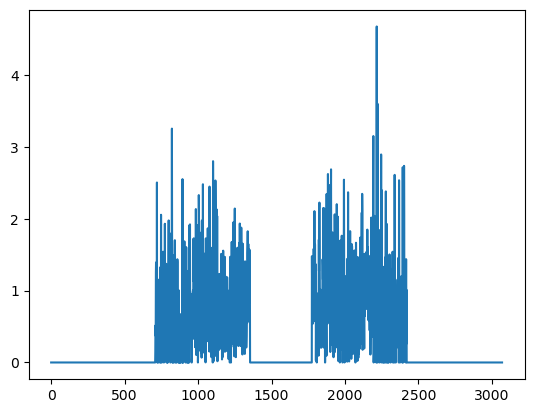

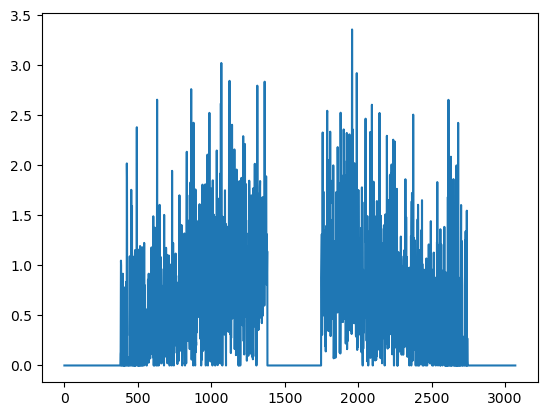

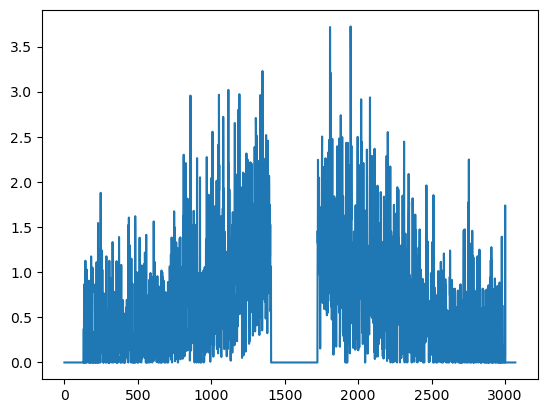

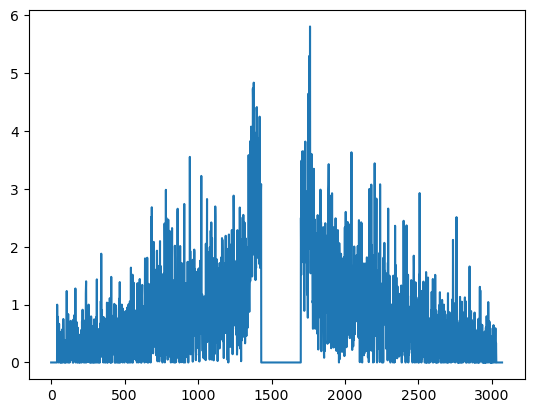

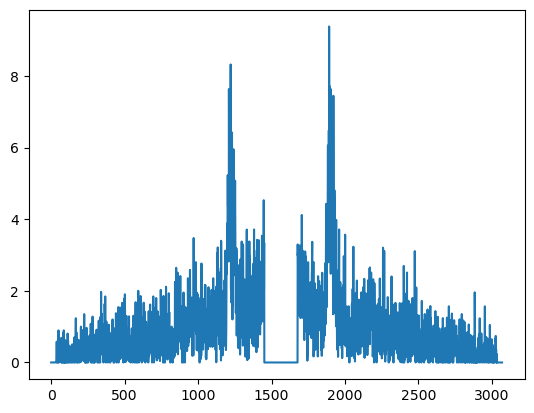

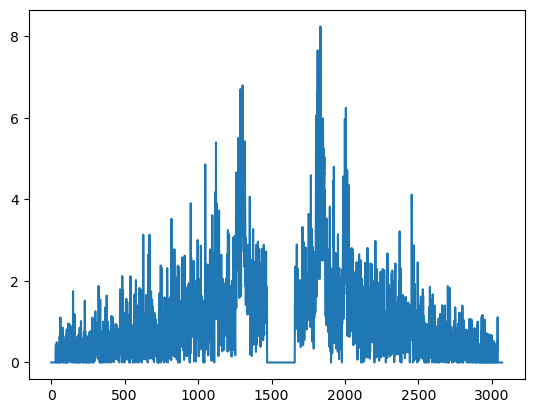

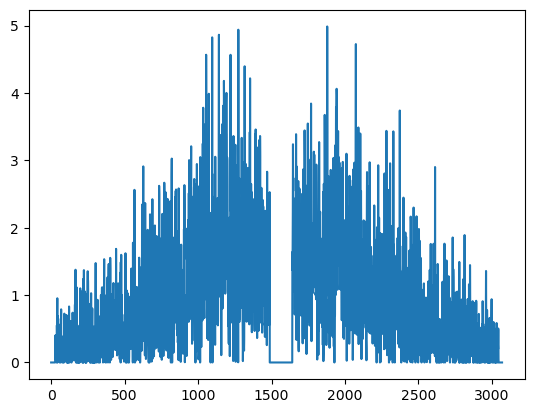

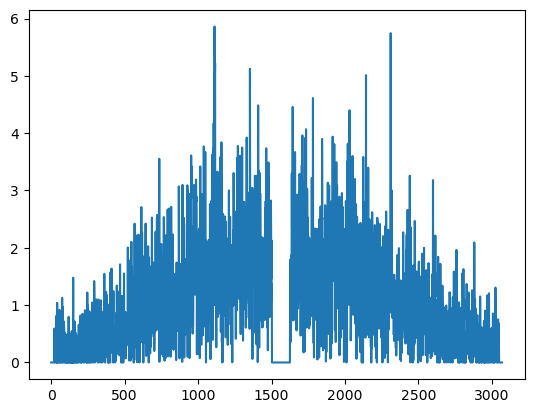

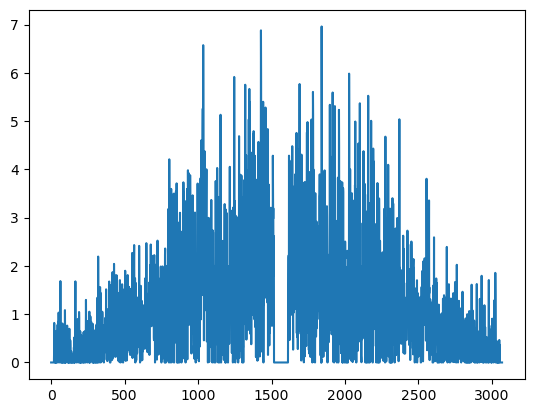

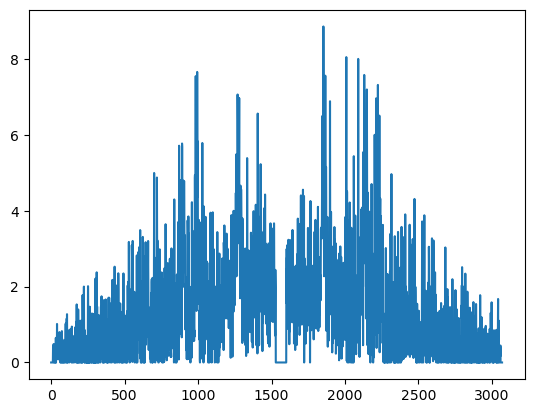

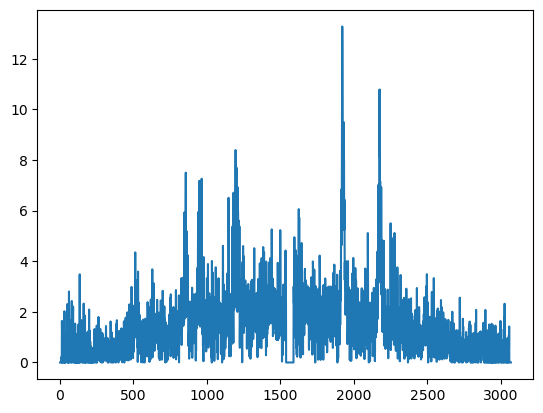

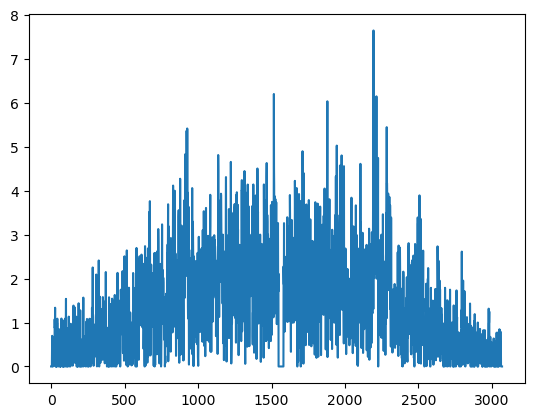

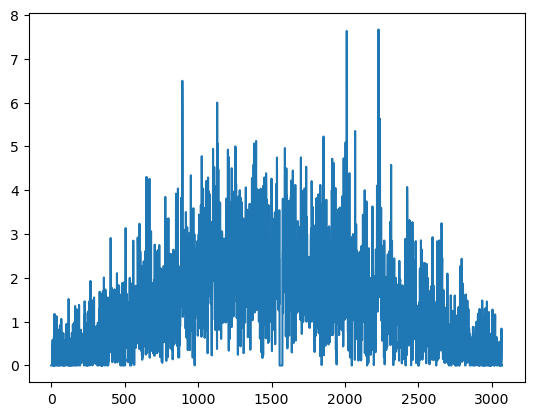

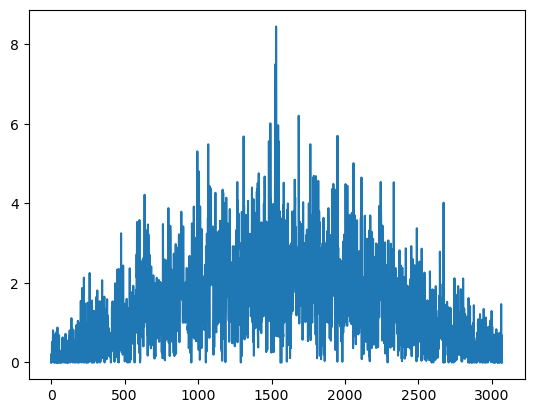

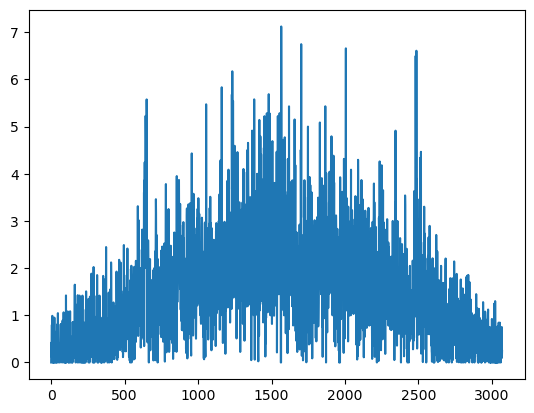

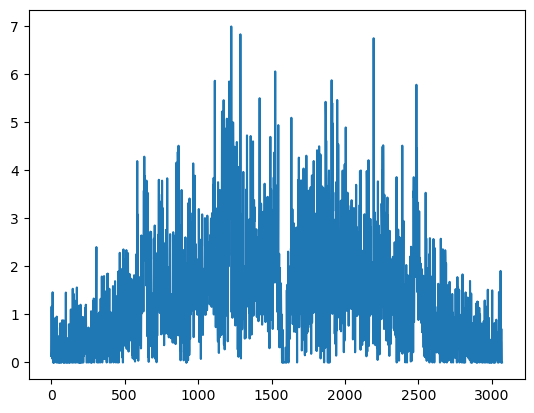

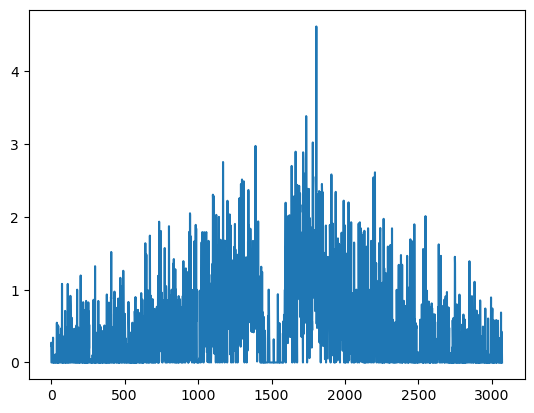

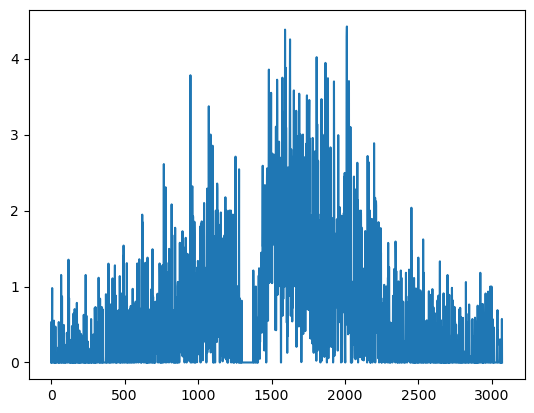

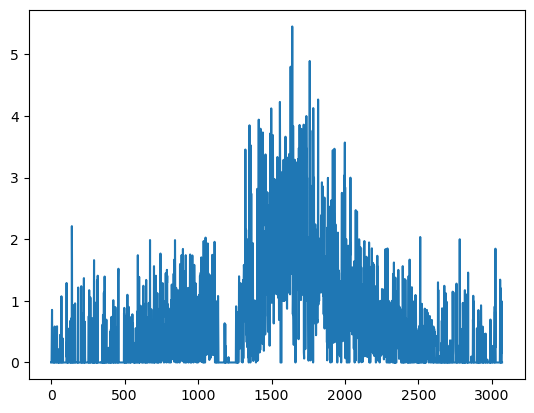

In [145]:
for ii in range(20):
    plt.figure()
    plt.plot(ii_2d[ii * 55, :])